In [124]:
import requests
import json
import pandas as pd
import re
import emoji
import flair
import matplotlib as plt

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

ApiKey = 'zq851ydtQ1XQi5UdNSMUPPInz'
ApiKeySecret = 'pKPlz171RVpaLlEESxDmRTvxuk452M8GEV92c786twfcuTs9y4'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAD3iVwEAAAAAp8IJMUXWf1wxFWiZfhACIHQXqSI%3DEOjIMXIXNZnXwXMpOi7p3ecqlMW7iOhwS8Dmbk5htotAzSFQmG'

sentiment_model = flair.models.TextClassifier.load('en-sentiment')


2021-11-20 17:50:37,029 loading file C:\Users\joaom\.flair\models\sentiment-en-mix-distillbert_4.pt


In [125]:
# Get User Data - Need elecated Access -  Waiting on approval by the Twitter Dev support team

# usersEndpoint = 'https://api.twitter.com/labs/2/users/'
# userFields = "created_at,description,pinned_tweet_id"
# userParams = {
#     "usernames": "TwitterDev",
#     "user.fields": userFields}

# headers = {'authorization': f'Bearer {bearer_token}'}

# userResponse = requests.get(usersEndpoint,
#                             params=userParams,
#                             headers=headers)  # send the requestprint(response)

# userResponse = userResponse.json()
def GetData(DailyBatchSize,DailyBatches,
StartHour,StartDay,EndDay,Month,Year):
    outputDataframe = pd.DataFrame()  
    endpoint = 'https://api.twitter.com/2/tweets/search/recent'
    headers = {'authorization': f'Bearer {bearer_token}'}
    for day in range(StartDay,EndDay+1):
        for batch in range(DailyBatches):
            hour = StartHour + 1 #get tweets one hour ahead
            params = {
                'query': '(tesla OR tesla Stock) (lang:en)', #add (tesla OR tsla) (type:popular)
                'max_results': f'{DailyBatchSize}',
                'end_time': f'{Year}-{Month}-{day}T{hour}:00:00Z',
                'tweet.fields': 'created_at,lang,author_id'} # 'media.fields': 'type'
            response = requests.get(endpoint,
                                        params=params,
                                        headers=headers)  # send the request

            # print(response.json())

            data = response.json()['data']
            df = pd.DataFrame.from_dict(data)
            outputDataframe = outputDataframe.append(df)
    outputDataframe.reset_index(drop=True, inplace=True)
    outputDataframe.style
    return outputDataframe

df = GetData(DailyBatchSize=10,
        DailyBatches=1, # max 12 (safety)
        StartHour = 10, #10 start 10am
        StartDay=14,
        EndDay=19,
        Month=11,
        Year=2021)

In [126]:

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

  
def cleanTweet(tweet):
    if 'RT' in tweet[:3]:
        tweet = tweet.replace('RT','')
    tweet = remove_emojis(tweet)
    tweet = tweet.replace(':','')
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    return tweet

def cleanDf(columnName):
    cleanList = []
    for tweet in df[columnName]:
        clean_tweet = cleanTweet(tweet)
        cleanList.append(clean_tweet)
    df[columnName] = cleanList
    dateList =  []
    for date in df['created_at']:
        date = str(date)[:10]
        dateList.append(date)
    df['created_at'] = dateList
    df['created_at']

cleanDf('text')



In [140]:

def addSentiment ():
    sentimentColumnN = []
    sentimentColumnL = []
    for tweet in df['text']:
        sentence = flair.data.Sentence(tweet)
        sentiment_model.predict(sentence)
        split_sentence = str(sentence.labels[0]).split(' ')
        numeric_score = split_sentence[1]
        label_score = split_sentence[0]
        sentimentColumnN.append(numeric_score)
        sentimentColumnL.append(label_score)
    df['Sentiment Outcome'] = sentimentColumnL
    df['Confidence Score'] = sentimentColumnN

addSentiment() # ref - took 1m46.3s to analyse 6 days at 100tweet/batch - 5 batches a day

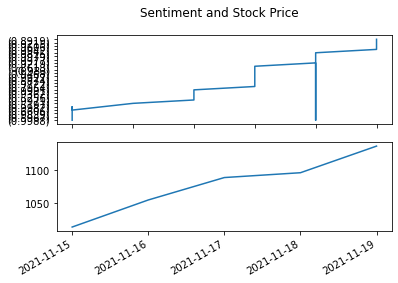

In [133]:
import numpy as np
score = df['Confidence Score'][df['Sentiment Outcome']=='POSITIVE']
date = df['created_at'][df['Sentiment Outcome']=='POSITIVE']

tesla  = pd.read_csv('tesla.csv')
teslaDate = tesla['Close'][tesla['Date'] > '2021-11-13' ]
close = tesla['Close'][tesla['Date'] > '2021-11-13' ]

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

tesla  = pd.read_csv('tesla.csv')
teslaDate = tesla['Date'][tesla['Date'] > '2021-11-13' ]
close = tesla['Close'][tesla['Date'] > '2021-11-13' ]


fig, axs = plt.subplots(2)
fig.suptitle('Sentiment and Stock Price')

axs[0].plot(date, score)
axs[1].plot(teslaDate, close)

fig.autofmt_xdate()
plt.show()

In [119]:
data = tesla[['Close','RSI']]
dataOBV = tesla[['Close','OBV']]

correlation = data.corr(method='pearson')
correlationOBV = dataOBV.corr(method='pearson')

print(correlation)
print(correlationOBV)


          Close       RSI
Close  1.000000  0.381268
RSI    0.381268  1.000000
          Close       OBV
Close  1.000000  0.389962
OBV    0.389962  1.000000


In [92]:
text = '''This makes no sense to me
Do people realize that other car manufacturers are and will also be making electric cars in the future?
Maybe people think Tesla stock doubles as a cryptocurrency...'''

sentence = flair.data.Sentence(text)
sentiment_model.predict(sentence)
sentence


Sentence: "This makes no sense to me Do people realize that other car manufacturers are and will also be making electric cars in the future ? Maybe people think Tesla stock doubles as a cryptocurrency ..."   [− Tokens: 35  − Sentence-Labels: {'label': [NEGATIVE (1.0)]}]

In [137]:
import requests
import json
import pandas as pd

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAD3iVwEAAAAAp8IJMUXWf1wxFWiZfhACIHQXqSI%3DEOjIMXIXNZnXwXMpOi7p3ecqlMW7iOhwS8Dmbk5htotAzSFQmG'
endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {'authorization': f'Bearer {bearer_token}'}

params = {
    'query': '(tesla OR tesla Stock) (lang:en)', 
    'max_results': '100',
    'end_time': '2021-11-20T15:00:00Z',
    'tweet.fields': 'created_at,lang,author_id'} # 'media.fields': 'type'
response = requests.get(endpoint,
                            params=params,
                            headers=headers) 

data = response.json()['data']
df = pd.DataFrame.from_dict(data)


In [138]:
cleanDf('text')
